# imports

In [1]:
from google.colab import drive.
drive.mount('/content/gdrive')
checkpoint_loc = '/content/gdrive/MyDrive/11785/project/'

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision import transforms

import copy
import types

In [3]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

INIT_LR = 0.1
WEIGHT_DECAY_RATE = 0.0005
EPOCHS = 70
REPEAT_WITH_DIFFERENT_SEED = 1

# Model

In [4]:
VGG_CONFIGS = {
    # M for MaxPool, Number for channels
    'D': [
        64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M',
        512, 512, 512, 'M'
    ],
}


class VGG_SNIP(nn.Module):
    """
    This is a base class to generate three VGG variants used in SNIP paper:
        1. VGG-C (16 layers)
        2. VGG-D (16 layers)
        3. VGG-like

    Some of the differences:
        * Reduced size of FC layers to 512
        * Adjusted flattening to match CIFAR-10 shapes
        * Replaced dropout layers with BatchNorm
    """

    def __init__(self, config, num_classes=10):
        super().__init__()

        self.features = self.make_layers(VGG_CONFIGS[config], batch_norm=True)

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),  # 512 * 7 * 7 in the original VGG
            nn.ReLU(True),
            nn.BatchNorm1d(512),  # instead of dropout
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),  # instead of dropout
            nn.Linear(512, num_classes),
        )

    @staticmethod
    def make_layers(config, batch_norm=False):  # TODO: BN yes or no?
        layers = []
        in_channels = 3
        for v in config:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [
                        conv2d,
                        nn.BatchNorm2d(v),
                        nn.ReLU(inplace=True)
                    ]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)  
        x = F.log_softmax(x, dim=1)
        return x

# Dataset and loaders

In [5]:
def get_cifar10_dataloaders(train_batch_size, test_batch_size):

    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

    train_dataset = CIFAR10('_dataset', True, train_transform, download=True)
    test_dataset = CIFAR10('_dataset', False, test_transform, download=False)

    train_loader = DataLoader(
        train_dataset,
        train_batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True)
    test_loader = DataLoader(
        test_dataset,
        test_batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True)

    return train_loader, test_loader

In [7]:
def cifar10_experiment():
    
    BATCH_SIZE = 128
    LR_DECAY_INTERVAL = 20
    
    net = VGG_SNIP('D').to(device)
    # net = 
    optimiser = optim.SGD(
        net.parameters(),
        lr=INIT_LR,
        momentum=0.9,
        weight_decay=WEIGHT_DECAY_RATE)
    lr_scheduler = optim.lr_scheduler.StepLR(
        optimiser, LR_DECAY_INTERVAL, gamma=0.1)
    
    train_loader, val_loader = get_cifar10_dataloaders(BATCH_SIZE,
                                                       BATCH_SIZE)  # TODO

    return net, optimiser, lr_scheduler, train_loader, val_loader

In [8]:
initial_net, optimiser, lr_scheduler, train_loader, val_loader = cifar10_experiment()
initial_net = initial_net.to(device)
torch.save(initial_net,'/content/init.pt')
initial_net


Extracting _dataset/cifar-10-python.tar.gz to _dataset


VGG_SNIP(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

# Pruning

SNIP

In [9]:
def snip_forward_conv2d(self, x):
        return F.conv2d(x, self.weight * self.weight_mask, self.bias,
                        self.stride, self.padding, self.dilation, self.groups)


def snip_forward_linear(self, x):
        return F.linear(x, self.weight * self.weight_mask, self.bias)


def SNIP(net, keep_ratio, train_dataloader, device):
    # TODO: shuffle?

    # Grab a single batch from the training dataset
    inputs, targets = next(iter(train_dataloader))
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Let's create a fresh copy of the network so that we're not worried about
    # affecting the actual training-phase
    net = copy.deepcopy(net)

    # Monkey-patch the Linear and Conv2d layer to learn the multiplicative mask
    # instead of the weights
    for layer in net.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            layer.weight_mask = nn.Parameter(torch.ones_like(layer.weight))
            nn.init.xavier_normal_(layer.weight)
            layer.weight.requires_grad = False

        # Override the forward methods:
        if isinstance(layer, nn.Conv2d):
            layer.forward = types.MethodType(snip_forward_conv2d, layer)

        if isinstance(layer, nn.Linear):
            layer.forward = types.MethodType(snip_forward_linear, layer)

    # Compute gradients (but don't apply them)
    net.zero_grad()
    outputs = net.forward(inputs)
    loss = F.nll_loss(outputs, targets)
    loss.backward()

    grads_abs = []
    for layer in net.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            grads_abs.append(torch.abs(layer.weight_mask.grad))

    # Gather all scores in a single vector and normalise
    all_scores = torch.cat([torch.flatten(x) for x in grads_abs])
    norm_factor = torch.sum(all_scores)
    all_scores.div_(norm_factor)

    num_params_to_keep = int(len(all_scores) * keep_ratio)
    threshold, _ = torch.topk(all_scores, num_params_to_keep, sorted=True)
    acceptable_score = threshold[-1]

    keep_masks = []
    for g in grads_abs:
        keep_masks.append(((g / norm_factor) >= acceptable_score).float())
        
    print(torch.sum(torch.cat([torch.flatten(x == 1) for x in keep_masks])))

    return (keep_masks)


In [10]:
def apply_prune_mask(net, keep_masks):

    # Before I can zip() layers and pruning masks I need to make sure they match
    # one-to-one by removing all the irrelevant modules:
    prunable_layers = filter(
        lambda layer: isinstance(layer, nn.Conv2d) or isinstance(
            layer, nn.Linear), net.modules())

    for layer, keep_mask in zip(prunable_layers, keep_masks):
        assert (layer.weight.shape == keep_mask.shape)

        def hook_factory(keep_mask):
            """
            The hook function can't be defined directly here because of Python's
            late binding which would result in all hooks getting the very last
            mask! Getting it through another function forces early binding.
            """

            def hook(grads):
                return grads * keep_mask

            return hook

        # mask[i] == 0 --> Prune parameter
        # mask[i] == 1 --> Keep parameter

        # Step 1: Set the masked weights to zero (NB the biases are ignored)
        # Step 2: Make sure their gradients remain zero
        layer.weight.data[keep_mask == 0.] = 0.
        layer.weight.register_hook(hook_factory(keep_mask))

# Pruning while training

In [11]:
def training(epoch, model, optimizer, scheduler, criterion, device, train_loader):
  model.train()
  avg_loss = 0.0
  av_loss=0.0
  total=0
  for batch_num, (feats, labels) in enumerate(train_loader):
      feats, labels = feats.to(device), labels.to(device)
      
      optimizer.zero_grad()

      outputs = model(feats)


      loss = criterion(outputs, labels.long())
      loss.backward()
      
      optimizer.step()
      
      avg_loss += loss.item()
      av_loss += loss.item() 
      total +=len(feats) 
      # if batch_num % 10 == 9:
      #     print('Epoch: {}\tBatch: {}\tAv-Loss: {:.4f}'.format(epoch+1, batch_num+1, av_loss/10))
      #     av_loss = 0.0

      torch.cuda.empty_cache()
      del feats
      del labels
      del loss

  del train_loader
  return avg_loss/total

In [12]:
import time

def validate(epoch, model, criterion, device, data_loader):
    start_time = time.time()
    with torch.no_grad():
        model.eval()
        running_loss, accuracy,total  = 0.0, 0.0, 0

        
        for i, (X, Y) in enumerate(data_loader):
            
            X, Y = X.to(device), Y.to(device)
            output= model(X)
            loss = criterion(output, Y.long())

            _,pred_labels = torch.max(F.softmax(output, dim=1), 1)
            pred_labels = pred_labels.view(-1)
            
            accuracy += torch.sum(torch.eq(pred_labels, Y)).item()

            running_loss += loss.item()
            total += len(X)

            torch.cuda.empty_cache()
            
            del X
            del Y
        
        return running_loss/total, accuracy/total, (time.time() - start_time)

In [ ]:
for _ in range(REPEAT_WITH_DIFFERENT_SEED):
      after_pruning_net, optimiser, lr_scheduler, train_loader, val_loader = cifar10_experiment()
      after_pruning_net = after_pruning_net.to(device)
      # Pre-training pruning using SKIP
      keep_masks = SNIP(after_pruning_net, 0.05, train_loader, device)  # TODO: shuffle?
      apply_prune_mask(after_pruning_net, keep_masks)
      
      criterion = nn.CrossEntropyLoss()

      for epoch in range(EPOCHS):
          train_loss = training(epoch, after_pruning_net, optimiser, lr_scheduler, criterion, device,train_loader)

          val_loss, val_acc = validate(epoch, after_pruning_net, criterion, device, val_loader)

          lr_scheduler.step()

          print('Epoch: {} \t train-Loss: {:.4f}, \tval-Loss: {:.4f}, \tval-acc: {:.4f}'.format(epoch+1,  train_loss, val_loss, val_acc))

      torch.save(after_pruning_net,checkpoint_loc+'depression_1.ptmodel')

In [13]:
# torch.save(net,'/content/gdrive/MyDrive/11785/project/deep depression/after_pruning.ptmodel')
after_pruning_net = torch.load('/content/gdrive/MyDrive/11785/project/deep depression/after_pruning.ptmodel')
# net = torch.load('after_pruning.ptmodel')

In [14]:
 criterion = nn.CrossEntropyLoss()
 val_loss, val_acc,time_taken = validate(0, after_pruning_net, criterion, device, val_loader)
 print(val_loss, ' ', val_acc,' ',time_taken)

0.0022592162996530533   0.9193   2.5314345359802246


# Quantization

Sparse matrix

In [15]:
import copy
quantization_net = copy.deepcopy(after_pruning_net)
quantization_net.features


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

Feature wide quantization

In [16]:
from sklearn.cluster import KMeans
import numpy as np
bits = 5
for layer, (name, module) in enumerate(quantization_net.features._modules.items()):
  print('-'*10,' name:', module)
  if not isinstance(module,nn.ReLU) and not isinstance(module,nn.MaxPool2d):
    dev = module.weight.device
    weight = module.weight.data.cpu().numpy()
    org_shape =  module.weight.shape

    flatten_weights = weight.flatten()
    min_ = np.min(flatten_weights)
    max_ = np.max(flatten_weights)
    space = np.linspace(min_, max_, num=2**bits)

    print(module.weight.flatten().size())
    kmeans = KMeans(n_clusters=len(space), init=space.reshape(-1,1), n_init=1, precompute_distances=True, algorithm="full")
    kmeans.fit(weight.reshape(-1,1))
    new_weight = kmeans.cluster_centers_[kmeans.labels_].reshape(-1)
    mat = new_weight.reshape(org_shape)
    module.weight.data = torch.from_numpy(mat).to(dev)

  else:
    print('skipped')

----------  name: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1728])
----------  name: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([64])
----------  name: ReLU(inplace=True)
skipped
----------  name: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([36864])
----------  name: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([64])
----------  name: ReLU(inplace=True)
skipped
----------  name: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
skipped
----------  name: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([73728])


KeyboardInterrupt: ignored

Classifier quantization

In [49]:
from sklearn.cluster import KMeans
import numpy as np
bits = 5
for layer, (name, module) in enumerate(quantization_net.classifier._modules.items()):
  print('-'*10,' name:', module)
  if not isinstance(module,nn.ReLU) and not isinstance(module,nn.MaxPool2d):
    dev = module.weight.device
    weight = module.weight.data.cpu().numpy()
    org_shape =  module.weight.shape

    flatten_weights = weight.flatten()
    min_ = np.min(flatten_weights)
    max_ = np.max(flatten_weights)
    space = np.linspace(min_, max_, num=2**bits)

    print(module.weight.flatten().size())
    kmeans = KMeans(n_clusters=len(space), init=space.reshape(-1,1), n_init=1, precompute_distances=True, algorithm="full")
    kmeans.fit(weight.reshape(-1,1))
    new_weight = kmeans.cluster_centers_[kmeans.labels_].reshape(-1)
    mat = new_weight.reshape(org_shape)
    module.weight.data = torch.from_numpy(mat).to(dev)

  else:
    print('skipped')

----------  name: Linear(in_features=512, out_features=512, bias=True)
torch.Size([262144])
----------  name: ReLU(inplace=True)
skipped
----------  name: BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([512])
----------  name: Linear(in_features=512, out_features=512, bias=True)
torch.Size([262144])
----------  name: ReLU(inplace=True)
skipped
----------  name: BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([512])
----------  name: Linear(in_features=512, out_features=10, bias=True)
torch.Size([5120])


In [17]:
quantization_net = torch.load('/content/gdrive/MyDrive/11785/project/deep depression/after_quantization.ptmodel')

In [51]:
 quantization_net.cuda()
 val_loss, val_acc,time_taken = validate(0, quantization_net, criterion, device, val_loader)
 print(val_acc,' ',time_taken)

0.9184   2.3771140575408936


In [ ]:
torch.save(quantization_net,'after_quantization.ptmodel')
torch.save(quantization_net,'/content/gdrive/MyDrive/11785/project/deep depression/after_quantization.ptmodel')

# Post quantization comparison

In [53]:
layer_names = []
post_quant_weights_unique = []
for layer, (name, module) in enumerate(quantization_net.features._modules.items()):
  print('-'*10,' name:', module)
  if not isinstance(module,nn.ReLU) and not isinstance(module,nn.MaxPool2d):
    weight = module.weight.data.cpu().numpy()
    flatten_weights = weight.flatten()
    layer_names.append(module.__class__.__name__)
    post_quant_weights_unique.append(np.unique(flatten_weights))
  else:
    print('skipped')
for layer, (name, module) in enumerate(quantization_net.classifier._modules.items()):
  print('-'*10,' name:', module)
  if not isinstance(module,nn.ReLU) and not isinstance(module,nn.MaxPool2d):
    weight = module.weight.data.cpu().numpy()
    flatten_weights = weight.flatten()
    layer_names.append(module.__class__.__name__)
    post_quant_weights_unique.append(np.unique(flatten_weights))
  else:
    print('skipped')

----------  name: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
----------  name: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
----------  name: ReLU(inplace=True)
skipped
----------  name: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
----------  name: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
----------  name: ReLU(inplace=True)
skipped
----------  name: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
skipped
----------  name: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
----------  name: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
----------  name: ReLU(inplace=True)
skipped
----------  name: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
----------  name: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
----------  name: ReLU(inplace=T

In [54]:
layer_names = []
pre_quant_weights_unique = []
for layer, (name, module) in enumerate(after_pruning_net.features._modules.items()):
  print('-'*10,' name:', module)
  if not isinstance(module,nn.ReLU) and not isinstance(module,nn.MaxPool2d):
    weight = module.weight.data.cpu().numpy()
    flatten_weights = weight.flatten()
    layer_names.append(module.__class__.__name__)
    pre_quant_weights_unique.append(np.unique(flatten_weights))
  else:
    print('skipped')
for layer, (name, module) in enumerate(after_pruning_net.classifier._modules.items()):
  print('-'*10,' name:', module)
  if not isinstance(module,nn.ReLU) and not isinstance(module,nn.MaxPool2d):
    weight = module.weight.data.cpu().numpy()
    flatten_weights = weight.flatten()
    layer_names.append(module.__class__.__name__)
    pre_quant_weights_unique.append(np.unique(flatten_weights))
  else:
    print('skipped')

----------  name: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
----------  name: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
----------  name: ReLU(inplace=True)
skipped
----------  name: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
----------  name: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
----------  name: ReLU(inplace=True)
skipped
----------  name: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
skipped
----------  name: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
----------  name: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
----------  name: ReLU(inplace=True)
skipped
----------  name: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
----------  name: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
----------  name: ReLU(inplace=T

In [55]:
if len(post_quant_weights_unique) == len(pre_quant_weights_unique):
  print('true')

true


In [59]:
i = 0
for old_w,new_w in zip(pre_quant_weights_unique,post_quant_weights_unique):
  print('layer_names [',layer_names[i],'] -> unique weights count old:',len(old_w),', new:',len(new_w))
  i+=1

layer_names [ Conv2d ] -> unique weights count old: 1590 , new: 32
layer_names [ BatchNorm2d ] -> unique weights count old: 64 , new: 32
layer_names [ Conv2d ] -> unique weights count old: 26883 , new: 32
layer_names [ BatchNorm2d ] -> unique weights count old: 64 , new: 32
layer_names [ Conv2d ] -> unique weights count old: 47853 , new: 32
layer_names [ BatchNorm2d ] -> unique weights count old: 128 , new: 32
layer_names [ Conv2d ] -> unique weights count old: 76178 , new: 32
layer_names [ BatchNorm2d ] -> unique weights count old: 128 , new: 32
layer_names [ Conv2d ] -> unique weights count old: 111327 , new: 32
layer_names [ BatchNorm2d ] -> unique weights count old: 256 , new: 32
layer_names [ Conv2d ] -> unique weights count old: 133452 , new: 32
layer_names [ BatchNorm2d ] -> unique weights count old: 256 , new: 32
layer_names [ Conv2d ] -> unique weights count old: 108554 , new: 32
layer_names [ BatchNorm2d ] -> unique weights count old: 256 , new: 32
layer_names [ Conv2d ] -> u

# casting post quantize weights to int

In [34]:
import copy
post_process_net = torch.load('/content/gdrive/MyDrive/11785/project/deep depression/after_quantization.ptmodel')

In [35]:
 val_loss, val_acc,time_taken = validate(0, post_process_net, criterion, device, val_loader)
 print(val_acc,time_taken)

0.9186 6.498332977294922


In [36]:
import torch.quantization
post_process_net = post_process_net.to('cpu')
device='cpu'
post_process_net.qconfig = torch.quantization.default_qconfig
torch.quantization.prepare(post_process_net, inplace=True)
torch.quantization.convert(post_process_net, inplace=True)

/usr/local/lib/python3.7/dist-packages/torch/quantization/observer.py:123: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."
/usr/local/lib/python3.7/dist-packages/torch/quantization/observer.py:245: UserWarning: must run observer before calling calculate_qparams.                                        Returning default scale and zero point 
  Returning default scale and zero point "


VGG_SNIP(
  (features): Sequential(
    (0): QuantizedConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
    (1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
    (4): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): QuantizedConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
    (8): QuantizedBatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): QuantizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
    (11): QuantizedBatchNorm2d(128, eps=1e-05, momentum=0.1, a

In [ ]:
 post_process_net.cpu()
 val_loss, val_acc,time_taken = validate(0, post_process_net, criterion, device, val_loader)
 print(val_acc,time_taken)

In [ ]:
torch.save(net,'after_quantization_int.ptmodel')
torch.save(net,'/content/gdrive/MyDrive/11785/project/deep depression/after_quantization_int.ptmodel')

# post int quantize weights comparison with quantize weights

In [ ]:
layer_names = []
post_quant_weights_int_unique = []
for layer, (name, module) in enumerate(net.features._modules.items()):
  print('-'*10,' name:', module)
  if not isinstance(module,nn.ReLU) and not isinstance(module,nn.MaxPool2d):
    weight = module.weight.data.cpu().numpy()
    flatten_weights = weight.flatten()
    post_quant_weights_int_unique.append(np.unique(flatten_weights))
  else:
    print('skipped')

# Visualization convolution weights

In [26]:
import matplotlib.pyplot as plt
def plot_filters_multi_channel(t,img_name):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig(img_name, dpi=100)    
    plt.tight_layout()
    plt.show()

In [24]:
def plot_weights(model, layer_num,img_name):
  
  layer = model.features[layer_num]
  
  if isinstance(layer, nn.Conv2d):
    weight_tensor = model.features[layer_num].weight.data
    if weight_tensor.shape[1] == 3:
      plot_filters_multi_channel(weight_tensor,img_name)
    else:
        print("Can only plot weights with three channels with single channel = False")     
  else:
    print("Can only visualize layers which are convolutional")

In [ ]:
import matplotlib.pyplot as plt
initial_net = initial_net.to('cpu')
after_pruning_net = after_pruning_net.to('cpu')
quantization_net = quantization_net.to('cpu')
plot_weights(initial_net, 0,'initial state of weights')
plot_weights(after_pruning_net, 0,'after pruning')
plot_weights(quantization_net, 0,'after quantization with k-means')

# Visualization Activation layer

Linear(in_features=512, out_features=512, bias=True)
[-2.62651205e-01 -2.00239673e-01 -1.52694285e-01 -1.30984098e-01
 -1.11580133e-01 -9.03302729e-02 -6.05782866e-02 -4.06768061e-02
 -2.74116416e-02 -1.84960216e-02 -1.17350705e-02 -5.85467555e-03
 -2.37078825e-03 -6.54769887e-04  2.78642801e-06  2.29578675e-03
  6.95845997e-03  1.36291971e-02  2.15460546e-02  3.15798894e-02
  4.34518382e-02  5.56850210e-02  6.92472532e-02  7.85576776e-02
  9.07434896e-02  1.12685129e-01  1.39182061e-01  1.52690858e-01
  1.75977081e-01  1.93883166e-01  2.74437904e-01  4.24591839e-01]


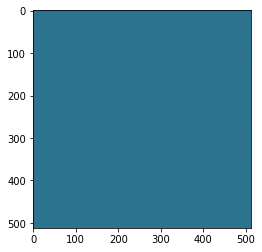

In [65]:
print(quantization_net.classifier[0])
quantization_net = quantization_net.to('cpu')
print(np.unique(quantization_net.classifier[0].weight.data.flatten()))
plt.imshow(quantization_net.classifier[0].weight.data)